# Binary Morphology Interactive Tool

This notebook provides an interactive interface for applying binary morphology operations to whale vocalization masks stored in HDF5 files.

## Features:
- Browse and select HDF5 files from a directory
- View available annotation classes
- Apply morphology operations (dilation, erosion, opening, closing)
- Adjust kernel size interactively
- Visualize results with before/after comparison
- Save processed masks to new HDF5 files

## 1. Setup and Imports

In [4]:
import sys
from pathlib import Path

# Add parent directory to path for imports
parent_dir = Path().absolute().parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Import our modules (from parent directory)
from bin_morph import (
    HDF5MorphologyProcessor,
    MaskMorphology,
    visualize_morphology_result,
    compare_multiple_operations
)
from ml_prep import HDF5SpectrogramLoader, list_hdf5_files

# Configure matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['figure.dpi'] = 100

print("✅ Imports complete!")
print(f"📁 Notebook location: {Path().absolute()}")
print(f"📁 Parent directory: {parent_dir}")

✅ Imports complete!
📁 Notebook location: /home/songbird/INI/whale_frequency_contour_publication/spectrace/demos
📁 Parent directory: /home/songbird/INI/whale_frequency_contour_publication/spectrace


## 2. Configure Data Directory

Set the path to your HDF5 files directory.

In [5]:
# 🔧 CONFIGURE THIS PATH
# HDF5_DIRECTORY = "/path/to/your/hdf5_files"

# Example:
HDF5_DIRECTORY = "/home/songbird/INI/whale_frequency_contour_publication/audio/hdf5_files"

# Validate directory
hdf5_dir = Path(HDF5_DIRECTORY)
if not hdf5_dir.exists():
    print(f"❌ Directory not found: {HDF5_DIRECTORY}")
    print("   Please update the path above.")
else:
    hdf5_files = list_hdf5_files(HDF5_DIRECTORY)
    print(f"✅ Found {len(hdf5_files)} HDF5 files in directory")
    
    if len(hdf5_files) > 0:
        print("\n📁 Sample files:")
        for f in hdf5_files[:5]:
            print(f"   - {f.name}")
        if len(hdf5_files) > 5:
            print(f"   ... and {len(hdf5_files) - 5} more")

✅ Found 47 HDF5 files in directory

📁 Sample files:
   - 2023-12-03--10-15-30--00-15-00--Ct-Dt--00-26--C_0.hdf5
   - 2023-12-03--10-15-30--00-15-00--Ct-Dt--00-26--C_1.hdf5
   - 2023-12-03--10-15-30--00-15-00--Ct-Dt--01-40--C_0.hdf5
   - 2023-12-03--10-15-30--00-15-00--Ct-Dt--03-52--D_0.hdf5
   - 2023-12-03--10-15-30--00-15-00--Ct-Dt--03-52--D_1.hdf5
   ... and 42 more


## 3. Interactive File Browser and Class Selector

Use the widgets below to:
1. Select an HDF5 file
2. View available classes (layers)
3. Select a class with annotations

In [12]:
# Create widgets
file_dropdown = widgets.Dropdown(
    options=[(f.name, str(f)) for f in hdf5_files],
    description='HDF5 File:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='600px')
)

class_dropdown = widgets.Dropdown(
    options=[],
    description='Class:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px')
)

info_output = widgets.Output()

def update_classes(change):
    """Update class dropdown when file changes."""
    with info_output:
        clear_output(wait=True)
        
        try:
            processor = HDF5MorphologyProcessor(change['new'])
            non_empty = processor.get_non_empty_classes()
            all_classes = processor.get_class_names()
            
            if non_empty:
                class_dropdown.options = non_empty
                class_dropdown.value = non_empty[0]
                
                print(f"📊 File Info:")
                print(f"   Total classes: {len(all_classes)}")
                print(f"   Non-empty classes: {len(non_empty)}")
                print(f"\n✅ Classes with annotations:")
                for cls in non_empty:
                    print(f"   - {cls}")
            else:
                class_dropdown.options = []
                print("⚠️  No non-empty classes found in this file")
                
        except Exception as e:
            print(f"❌ Error loading file: {e}")
            class_dropdown.options = []

# Connect file dropdown to update function
file_dropdown.observe(update_classes, names='value')

# Initialize with first file
if len(hdf5_files) > 0:
    update_classes({'new': file_dropdown.value})

# Display widgets
display(widgets.VBox([
    widgets.HTML("<h3>📂 File and Class Selection</h3>"),
    file_dropdown,
    class_dropdown,
    info_output
]))

## 4. Preview Selected Data

Visualize the spectrogram and selected mask.

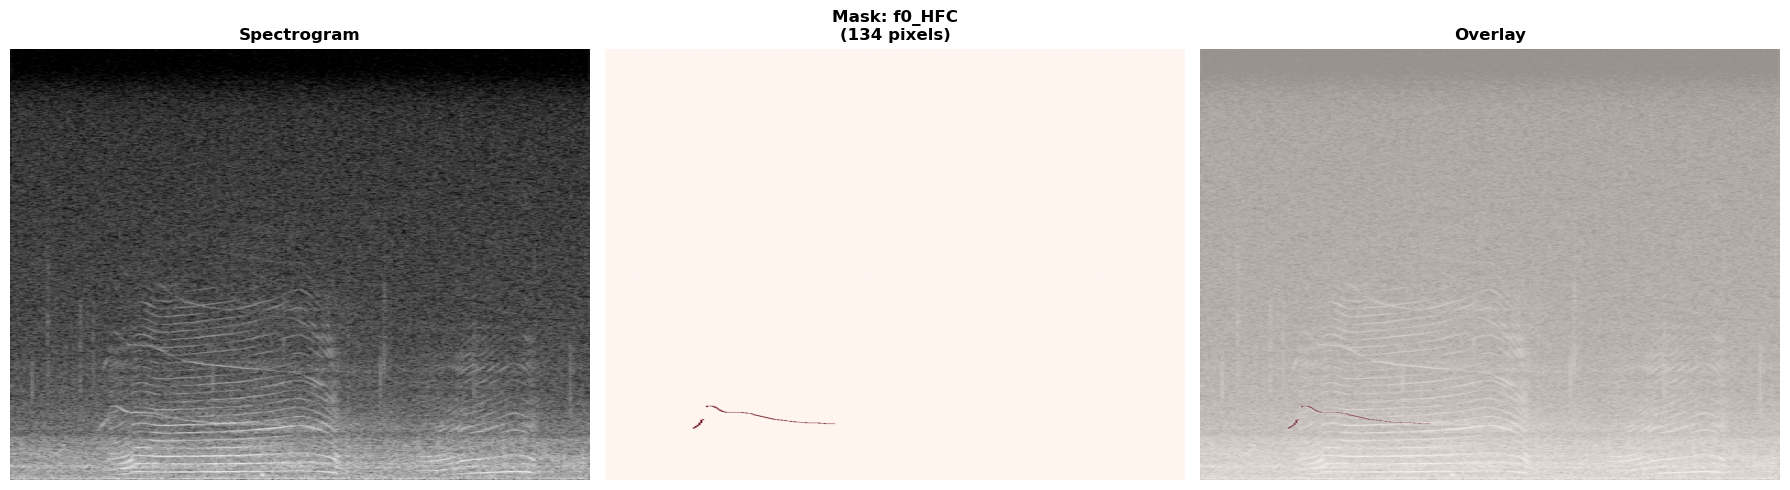


📊 Data Info:
   File: 2023-12-03--10-15-30--00-15-00--Ct-Dt--00-26--C_0.hdf5
   Class: f0_HFC
   Spectrogram shape: (1025, 310)
   Mask pixels: 134


In [7]:
# Load and display selected data
try:
    processor = HDF5MorphologyProcessor(file_dropdown.value)
    spectrogram = processor.load_spectrogram()
    mask = processor.load_class_mask(class_dropdown.value)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Spectrogram
    axes[0].imshow(spectrogram, cmap='gray', aspect='auto')
    axes[0].set_title('Spectrogram', fontsize=12, weight='bold')
    axes[0].axis('off')
    
    # Mask alone
    axes[1].imshow(mask, cmap='Reds', aspect='auto')
    axes[1].set_title(f'Mask: {class_dropdown.value}\n({mask.sum()} pixels)', 
                      fontsize=12, weight='bold')
    axes[1].axis('off')
    
    # Overlay
    axes[2].imshow(spectrogram, cmap='gray', aspect='auto')
    axes[2].imshow(mask, cmap='Reds', aspect='auto', alpha=0.6)
    axes[2].set_title('Overlay', fontsize=12, weight='bold')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Data Info:")
    print(f"   File: {Path(file_dropdown.value).name}")
    print(f"   Class: {class_dropdown.value}")
    print(f"   Spectrogram shape: {spectrogram.shape}")
    print(f"   Mask pixels: {mask.sum()}")
    
except Exception as e:
    print(f"❌ Error: {e}")

## 5. Interactive Morphology Operations

Apply morphology operations with interactive controls.

In [ ]:
# Create interactive widgets
operation_dropdown = widgets.Dropdown(
    options=['dilation', 'erosion', 'opening', 'closing'],
    value='dilation',
    description='Operation:',
    style={'description_width': 'initial'}
)

kernel_slider = widgets.IntSlider(
    value=3,
    min=3,
    max=15,
    step=2,
    description='Kernel Size:',
    style={'description_width': 'initial'},
    continuous_update=False
)

kernel_shape_dropdown = widgets.Dropdown(
    options=['square', 'cross'],
    value='square',
    description='Kernel Shape:',
    style={'description_width': 'initial'}
)

apply_button = widgets.Button(
    description='Apply Operation',
    button_style='primary',
    icon='play'
)

output_area = widgets.Output()

# Store result globally so we can save it later
current_result = None

def apply_morphology(button):
    """Apply morphology operation and display results."""
    global current_result
    
    with output_area:
        clear_output(wait=True)
        
        try:
            print("🔧 Applying operation...")
            
            processor = HDF5MorphologyProcessor(file_dropdown.value)
            spectrogram = processor.load_spectrogram()
            
            result = processor.apply_to_class(
                class_name=class_dropdown.value,
                operation=operation_dropdown.value,
                kernel_size=kernel_slider.value,
                kernel_shape=kernel_shape_dropdown.value
            )
            
            current_result = result
            
            # Display statistics
            print(f"\n📊 Results:")
            print(f"   Operation: {result.operation}")
            print(f"   Kernel size: {result.kernel_size}")
            print(f"   Before: {result.pixel_count_before} pixels")
            print(f"   After: {result.pixel_count_after} pixels")
            print(f"   Change: {result.pixel_change:+d} pixels ({result.pixel_change_percent:+.1f}%)")
            print()
            
            # Visualize
            visualize_morphology_result(result, spectrogram)
            
        except Exception as e:
            print(f"❌ Error: {e}")
            import traceback
            traceback.print_exc()

apply_button.on_click(apply_morphology)

# Display interactive interface
display(widgets.VBox([
    widgets.HTML("<h3>🔧 Morphology Operation Controls</h3>"),
    operation_dropdown,
    kernel_slider,
    kernel_shape_dropdown,
    apply_button,
    output_area
]))

## 6. Compare Multiple Operations

Compare all operations side-by-side with different kernel sizes.

📊 Comparing all operations...



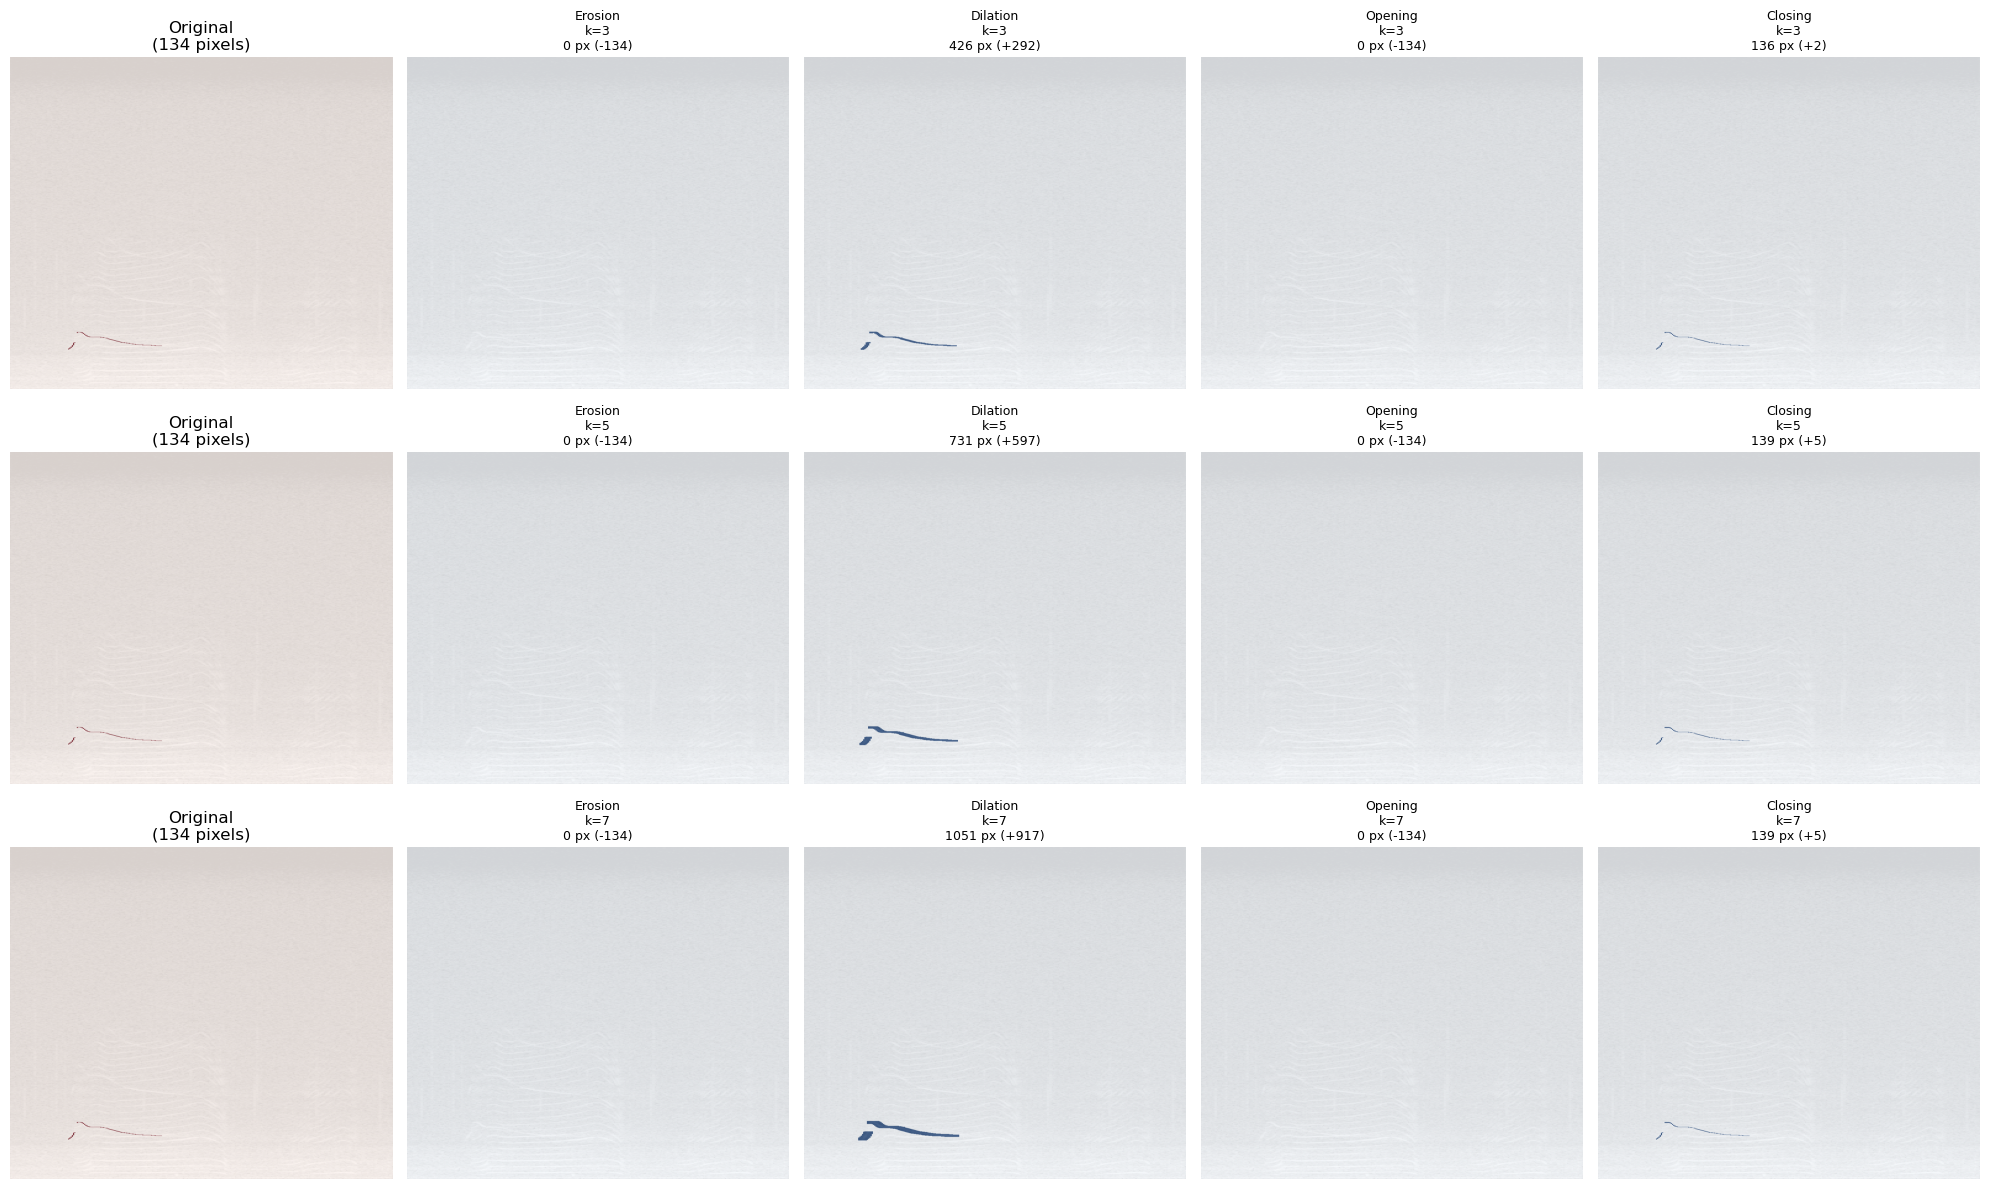

In [9]:
try:
    processor = HDF5MorphologyProcessor(file_dropdown.value)
    spectrogram = processor.load_spectrogram()
    mask = processor.load_class_mask(class_dropdown.value)
    
    print("📊 Comparing all operations...\n")
    
    compare_multiple_operations(
        mask=mask,
        spectrogram=spectrogram,
        operations=['erosion', 'dilation', 'opening', 'closing'],
        kernel_sizes=[3, 5, 7],
        figsize=(20, 12)
    )
    
except Exception as e:
    print(f"❌ Error: {e}")

## 7. Save Processed Mask

Save the processed mask to a new HDF5 file.

In [10]:
# Widget for output path
output_path_text = widgets.Text(
    value='',
    placeholder='output_processed.hdf5',
    description='Output file:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='600px')
)

save_button = widgets.Button(
    description='Save Processed Mask',
    button_style='success',
    icon='save'
)

save_output = widgets.Output()

def save_result(button):
    """Save the processed mask to a new HDF5 file."""
    global current_result
    
    with save_output:
        clear_output(wait=True)
        
        if current_result is None:
            print("⚠️  No processed mask to save. Apply an operation first.")
            return
        
        output_path = output_path_text.value.strip()
        if not output_path:
            print("⚠️  Please specify an output file path.")
            return
        
        # Add .hdf5 extension if not present
        if not output_path.endswith('.hdf5'):
            output_path += '.hdf5'
        
        # If relative path, put it in the same directory as input
        if not Path(output_path).is_absolute():
            output_path = str(Path(file_dropdown.value).parent / output_path)
        
        try:
            processor = HDF5MorphologyProcessor(file_dropdown.value)
            processor.save_processed_mask(
                class_name=class_dropdown.value,
                processed_mask=current_result.processed_mask,
                output_path=output_path,
                overwrite=True
            )
            
            print(f"\n📊 Saved Info:")
            print(f"   File: {output_path}")
            print(f"   Class: {class_dropdown.value}")
            print(f"   Operation: {current_result.operation}")
            print(f"   Kernel size: {current_result.kernel_size}")
            
        except Exception as e:
            print(f"❌ Error saving: {e}")
            import traceback
            traceback.print_exc()

save_button.on_click(save_result)

# Display save interface
display(widgets.VBox([
    widgets.HTML("<h3>💾 Save Processed Mask</h3>"),
    widgets.HTML("<p>The output file will contain a copy of the original data with the processed mask replacing the selected class.</p>"),
    output_path_text,
    save_button,
    save_output
]))

## 8. Batch Processing (Optional)

Apply the same operation to multiple files.

In [ ]:

def batch_process(
    hdf5_directory: str,
    operation: str,
    kernel_size: int = 3,
    kernel_shape: str = 'square',
    output_suffix: str = '_processed'
):
    """
    Apply morphology operation to all non-empty classes in all HDF5 files.
    
    Args:
        hdf5_directory: Directory containing HDF5 files
        operation: Morphology operation to apply
        kernel_size: Kernel size
        kernel_shape: 'square' or 'cross'
        output_suffix: Suffix to add to output filenames
    """
    files = list_hdf5_files(hdf5_directory)
    output_dir = Path(hdf5_directory) / 'processed'
    output_dir.mkdir(exist_ok=True)
    
    print(f"🔧 Batch processing {len(files)} files...")
    print(f"   Operation: {operation}, kernel_size: {kernel_size}")
    print(f"   Output directory: {output_dir}\n")
    
    for idx, hdf5_path in enumerate(files, 1):
        print(f"[{idx}/{len(files)}] Processing: {hdf5_path.name}")
        
        try:
            processor = HDF5MorphologyProcessor(str(hdf5_path))
            non_empty = processor.get_non_empty_classes()
            
            if not non_empty:
                print("  ⏭️  No non-empty classes, skipping")
                continue
            
            # Process first non-empty class (modify as needed)
            class_name = non_empty[0]
            
            result = processor.apply_to_class(
                class_name=class_name,
                operation=operation,
                kernel_size=kernel_size,
                kernel_shape=kernel_shape
            )
            
            # Save to output directory
            output_name = hdf5_path.stem + output_suffix + '.hdf5'
            output_path = output_dir / output_name
            
            processor.save_processed_mask(
                class_name=class_name,
                processed_mask=result.processed_mask,
                output_path=str(output_path),
                overwrite=True
            )
            
            print(f"  ✅ {class_name}: {result.pixel_count_before} → {result.pixel_count_after} pixels")
            
        except Exception as e:
            print(f"  ❌ Error: {e}")
    
    print(f"\n✅ Batch processing complete!")
    print(f"   Output directory: {output_dir}")

# Example usage (uncomment to run):
# batch_process(
#     hdf5_directory=HDF5_DIRECTORY,
#     operation='dilation',
#     kernel_size=3,
#     output_suffix='_dilated'
# )

## Summary

This notebook provides:
- ✅ Interactive file and class selection
- ✅ Real-time morphology operations
- ✅ Before/after visualization
- ✅ Multiple operation comparison
- ✅ Save processed masks
- ✅ Batch processing capability

### Next Steps:
1. Experiment with different operations and kernel sizes
2. Save useful processed masks for ML training
3. Use batch processing for consistent preprocessing
4. Integrate with your ML pipeline